In [1]:
!pip install pytorch-transformers
!pip install transformers

     |████████████████████████████████| 184kB 5.3MB/s 
     |████████████████████████████████| 890kB 16.7MB/s 
     |████████████████████████████████| 133kB 17.3MB/s 
     |████████████████████████████████| 1.1MB 20.2MB/s 
     |████████████████████████████████| 6.7MB 52.7MB/s 
     |████████████████████████████████| 71kB 10.8MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=ab96cc3e1e57be2a39618b8b5f0c8be1baa784f65036d8d02eb719f6c82a9a1c
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
ERROR: botocore 1.19.9 has requirement urllib3<1.26,>=1.25.4; python_version != "3.4", but you'll have urllib3 1.24.3 which is incompatible.
     |████████████████████████████████| 1.3MB 4.5MB/s 
     |████████████████████████████████| 2.9MB 19.0MB/s 


In [47]:
import re
import time
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from transformers import XLNetModel, XLNetTokenizer, XLNetForSequenceClassification
from transformers import AdamW
from sklearn.metrics import classification_report
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

In [3]:
df_train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Datasets and weights/Constraint_English_Train - Sheet1.csv')
df_val = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Datasets and weights/Constraint_English_Val - Sheet1.csv')

In [4]:
df_train['label'], uniq = pd.factorize(df_train['label'])

In [5]:
print(uniq)

Index(['real', 'fake'], dtype='object')


In [6]:
df_val['label'] = df_val['label'].map({'real':0,'fake':1})

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla T4'

In [8]:
train_sentences = df_train['tweet'].values.tolist()
val_sentences = df_val['tweet'].values.tolist()

In [9]:
def preprocess_texts(sentences):
  sentences = [re.sub(r'http\S+','',s) for s in sentences]
  sentences = [s.replace('#','') for s in sentences]
  sentences = [s + " [SEP] [CLS]" for s in sentences]
  return sentences

In [10]:
train_sentences = preprocess_texts(train_sentences)
val_sentences = preprocess_texts(val_sentences)

In [23]:
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased', do_lower_case=True)

tokenized_texts_train = [tokenizer.tokenize(s) for s in train_sentences]
tokenized_texts_val = [tokenizer.tokenize(s) for s in val_sentences]
print (tokenized_texts_train[0])


['▁the', '▁c', 'd', 'c', '▁currently', '▁reports', '▁9', '90', '31', '▁deaths', '.', '▁in', '▁general', '▁the', '▁discrepancies', '▁in', '▁death', '▁counts', '▁between', '▁different', '▁sources', '▁are', '▁small', '▁and', '▁', 'exp', 'lic', 'able', '.', '▁the', '▁death', '▁toll', '▁stands', '▁at', '▁roughly', '▁100', '000', '▁people', '▁today', '.', '▁[', 's', 'ep', ']', '▁[', 'cl', 's', ']']


In [13]:
df_train['len'] = [len(s.split()) for s in df_train['tweet']]
df_val['len'] = [len(s.split()) for s in df_val['tweet']]

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


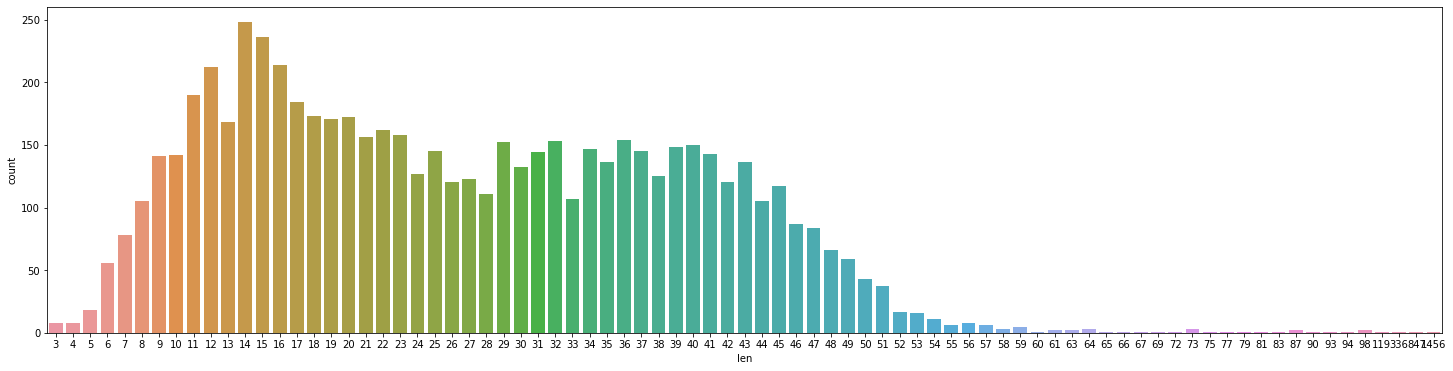

In [14]:
plt.figure(figsize=(25,6))
sns.countplot(df_train['len'])

In [24]:
MAX_LEN = 128
input_ids_train = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts_train]
input_ids_val = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts_val]

input_ids_train = pad_sequences(input_ids_train, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
input_ids_val = pad_sequences(input_ids_val, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [25]:
attention_masks_train = []
attention_masks_val = []

for seq in input_ids_train:
  seq_mask = [float(i>0) for i in seq]
  attention_masks_train.append(seq_mask)

for seq in input_ids_val:
  seq_mask = [float(i>0) for i in seq]
  attention_masks_val.append(seq_mask)

In [17]:
train_labels, validation_labels = df_train['label'].values.tolist(), df_val['label'].values.tolist()

In [26]:
train_inputs = torch.tensor(input_ids_train)
validation_inputs = torch.tensor(input_ids_val)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(attention_masks_train)
validation_masks = torch.tensor(attention_masks_val)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


In [27]:
train_inputs.shape

torch.Size([6420, 128])

In [28]:
batch_size = 32

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [29]:
model = XLNetForSequenceClassification.from_pretrained("xlnet-base-cased", num_labels=2)
model.cuda()

/usr/local/lib/python3.6/dist-packages/transformers/configuration_xlnet.py:212: FutureWarning: This config doesn't use attention memories, a core feature of XLNet. Consider setting `mem_len` to a non-zero value, for example `xlnet = XLNetLMHeadModel.from_pretrained('xlnet-base-cased'', mem_len=1024)`, for accurate training performance as well as an order of magnitude faster inference. Starting from version 3.5.0, the default parameter will be 1024, following the implementation in https://arxiv.org/abs/1906.08237
  FutureWarning,


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.weight', 'sequence_summary.summary.bias', 'logits_proj.weight', 'logits_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

XLNetForSequenceClassification(
  (transformer): XLNetModel(
    (word_embedding): Embedding(32000, 768)
    (layer): ModuleList(
      (0): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (layer_1): Linear(in_features=768, out_features=3072, bias=True)
          (layer_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (1): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e

In [30]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

In [34]:
optimizer = AdamW(optimizer_grouped_parameters,
                     lr=2e-5)

In [40]:
def epoch_time(start_time, end_time):
  elapsed_time = end_time - start_time
  elapsed_mins = int(elapsed_time / 60)
  elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
  return elapsed_mins, elapsed_secs

In [48]:
train_loss_set = []

epochs = 5

for _ in trange(epochs, desc="Epoch"):
  start_time = time.time()
  model.train()
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  
  for step, batch in enumerate(train_dataloader):

    batch = tuple(t.to(device) for t in batch)
  
    b_input_ids, b_input_mask, b_labels = batch

    optimizer.zero_grad()
  
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    
    loss = outputs[0]
    logits = outputs[1]
    train_loss_set.append(loss.item())    
    
    loss.backward()

    optimizer.step()
    
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1
  end_time = time.time()

  print(epoch_time(start_time,end_time))

  print("\nTrain loss: {}".format(tr_loss/nb_tr_steps))
  #print("\nTrain accuracy : {}".format(100 * correct / total))



Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  20%|██        | 1/5 [02:50<11:21, 170.48s/it]

(2, 50)

Train loss: 0.007013195815457196




Epoch:  40%|████      | 2/5 [05:46<08:36, 172.12s/it]

(2, 55)

Train loss: 0.0004388891717207483




Epoch:  60%|██████    | 3/5 [08:43<05:47, 173.66s/it]

(2, 57)

Train loss: 0.0001110288317815403




Epoch:  80%|████████  | 4/5 [11:41<02:54, 174.93s/it]

(2, 57)

Train loss: 0.010494523060682768




Epoch: 100%|██████████| 5/5 [14:39<00:00, 175.92s/it]

(2, 58)

Train loss: 0.008437383821602177


In [49]:
preds = []
with torch.no_grad():
  correct = 0
  total = 0
  for i, batch in enumerate(validation_dataloader):
    batch = tuple(t.to(device) for t in batch)

    b_input_ids, b_input_mask, b_labels = batch
    
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    # print (outputs)
    prediction = torch.argmax(outputs[0],dim=1)
    preds.append(prediction)
    total += b_labels.size(0)
    correct+=(prediction==b_labels).sum().item()

In [50]:
print('Test Accuracy of the model {} %'.format(100 * correct / total))

Test Accuracy of the model 97.00934579439253 %


In [58]:
final_preds = []
for tensor in preds:
  for pred in tensor:
    final_preds.append(int(pred))

In [59]:
print(classification_report(df_val['label'].values.tolist(),final_preds))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1120
           1       0.97      0.97      0.97      1020

    accuracy                           0.97      2140
   macro avg       0.97      0.97      0.97      2140
weighted avg       0.97      0.97      0.97      2140

